# Roberta - Hyperparameter Tuning

## Setup

### Import Libraries


In [1]:
!pip install -q optuna
!pip install -q evaluate
!pip install -q emoji==0.6.0
!pip install -q tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import *
import json
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler


import optuna
import wandb

import time
from tqdm import tqdm
import logging

from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd

from torch.cuda.amp import autocast, GradScaler

### Device Configuration


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
### Weights & Biases Setup
wandb.login(key="<wandb key>")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mayachn3 (mayachn3-maya-bondar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Load Dataset


In [7]:
train = pd.read_csv("OOT_train.csv", encoding='latin-1')
val = pd.read_csv("OOT_val.csv", encoding='latin-1')
test = pd.read_csv("OOT_test.csv", encoding='latin-1')


In [8]:
# train = train.head(100)
# val = val.head(100)
# test = test.head(100)

### preprocessing

In [9]:
#encoding the labels numerically from Sentiment
ordinal_mapping = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

# map to ordinal labels
train["label_id"] = train["Sentiment"].map(ordinal_mapping)
val["label_id"] = val["Sentiment"].map(ordinal_mapping)
test["label_id"] = test["Sentiment"].map(ordinal_mapping)



In [10]:
# Concat the relevant columns into one string with seperation.
# for example: "Tweet: my food stock is low | Location: Canada | Date: 2020-03-17 | URL: https://t.co/abcd"

# Function to build the input string from multiple columns
def build_augmented_input(row):
    parts = []

    if pd.notna(row.get('clean_tweet')):
        parts.append(f"{row['clean_tweet']}")

    if pd.notna(row.get('Location_standardized')) and row['Location_standardized'].lower() != 'unknown':
        parts.append(f"{row['Location_standardized']}")

    if pd.notna(row.get('TweetAt')):
        parts.append(f"{row['TweetAt']}")

    return " | ".join(parts)

# Apply to the DataFrames
train['model_input'] = train.apply(build_augmented_input, axis=1)
val['model_input'] = val.apply(build_augmented_input, axis=1)
test['model_input'] = test.apply(build_augmented_input, axis=1)

# Create  new DataFrames with only what's needed for modeling
formatted_train = train[['model_input', 'label_id']].copy()
formatted_val = val[['model_input', 'label_id']].copy()
formatted_test = test[['model_input', 'label_id']].copy()



In [11]:
def balance_dataset(df, target_samples_per_class=5000):
    """Balance dataset by undersampling"""
    balanced_dfs = []

    print("Original class distribution:")
    print(df['label_id'].value_counts().sort_index())

    for class_id in range(5):
        class_data = df[df['label_id'] == class_id]

        if len(class_data) > target_samples_per_class:
            class_data = class_data.sample(n=target_samples_per_class, random_state=42)
            print(f"Class {class_id}: {len(class_data)} samples (undersampled)")
        else:
            print(f"Class {class_id}: {len(class_data)} samples (kept all)")

        balanced_dfs.append(class_data)

    balanced_df = pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=42)

    print(f"Balanced dataset: {len(balanced_df)} total samples")
    print("New distribution:")
    print(balanced_df['label_id'].value_counts().sort_index())

    return balanced_df

# Apply balancing to training data
formatted_train = balance_dataset(formatted_train, target_samples_per_class=5000)

Original class distribution:
label_id
0     5175
1     9230
2     6784
3    10140
4     5845
Name: count, dtype: int64
Class 0: 5000 samples (undersampled)
Class 1: 5000 samples (undersampled)
Class 2: 5000 samples (undersampled)
Class 3: 5000 samples (undersampled)
Class 4: 5000 samples (undersampled)
Balanced dataset: 25000 total samples
New distribution:
label_id
0    5000
1    5000
2    5000
3    5000
4    5000
Name: count, dtype: int64


## Tokenization and Dataset Preparation

In [12]:
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(data, max_length=128):
    return tokenizer(
        data['model_input'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False
    )

train_encodings = tokenize_data(formatted_train)
val_encodings = tokenize_data(formatted_val)
test_encodings = tokenize_data(formatted_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [13]:
## define a PyTorch Dataset
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels  # Should be integers

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # For training
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to integers if not already
train_labels = formatted_train['label_id'].tolist()
val_labels = formatted_val['label_id'].tolist()
test_labels = formatted_test['label_id'].tolist()


train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)
test_dataset = TweetDataset(test_encodings, test_labels)


In [14]:

# define mapping between label id and sentiment for later use and conveniency
ordinal_label2id = ordinal_mapping
ordinal_id2label = {v: k for k, v in ordinal_mapping.items()}


### Model

In [15]:
def save_training_checkpoint(model, optimizer, scheduler, epoch, loss, trial_params, filepath, trial_number, current_score, best_score, model_name="cardiffnlp/twitter-roberta-base"):
    """Save complete training checkpoint and handle best model updates"""
    global global_best_qwk, global_best_model_state

    # Get the trial directory from filepath
    trial_dir = os.path.dirname(filepath)

    # Save trial checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'loss': loss,
        'trial_params': trial_params,
        'model_config': model.config.to_dict(),
        'model_name': model_name,
        'current_score': current_score,
        'trial_number': trial_number,
    }

    # Save all trial files in the same directory
    torch.save(checkpoint, filepath)
    torch.save(model.state_dict(), os.path.join(trial_dir, 'model_roberta_weights.pt'))
    torch.save(model, os.path.join(trial_dir, 'model_roberta.pt'))

    print(f"✅ Trial checkpoint saved: {filepath}")
    print(f"✅ Model files saved in: {trial_dir}")

    # Update best model if needed
    if current_score > best_score:
        best_model_path = "./best_roberta_model_so_far"

        # Ensure best model directory exists
        os.makedirs(best_model_path, exist_ok=True)

        # Save our custom .pt files in best model directory
        best_checkpoint_path = os.path.join(best_model_path, 'best_checkpoint.ckpt')
        best_weights_path = os.path.join(best_model_path, 'model_roberta_weights.pt')
        best_model_file_path = os.path.join(best_model_path, 'model_roberta.pt')

        torch.save(checkpoint, best_checkpoint_path)
        torch.save(model.state_dict(), best_weights_path)
        torch.save(model, best_model_file_path)

        # Update global variables
        global_best_qwk = current_score
        global_best_model_state = model.state_dict().copy()

        print(f"🏆 New best model saved! Score: {current_score:.4f} (Trial {trial_number})")
        print(f"🏆 Best model files saved in: {best_model_path}")

        return True  # Indicates new best model
    else:
        print(f"📊 Trial {trial_number} score: {current_score:.4f} (Best: {best_score:.4f})")
        return False

In [16]:
def calculate_per_class_metrics(y_true, y_pred, class_names):
    """Calculate detailed per-class metrics"""
    # Get per-class precision, recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
    )

    # Calculate per-class accuracy (correct predictions for each class)
    per_class_accuracy = []
    for class_id in range(len(class_names)):
        class_mask = (y_true == class_id)
        if class_mask.sum() > 0:  # If class exists in true labels
            class_acc = ((y_pred == class_id) & (y_true == class_id)).sum() / class_mask.sum()
        else:
            class_acc = 0.0
        per_class_accuracy.append(class_acc)

    return precision, recall, f1, per_class_accuracy


def print_epoch_summary_table(epoch, train_loss, train_accuracy, val_loss, val_accuracy,
                             val_precision, val_recall, val_f1, val_mae, val_adjacent_accuracy,
                             val_qwk, per_class_metrics, class_names, epoch_time):
    """Print a comprehensive epoch summary table"""

    precision, recall, f1, per_class_accuracy = per_class_metrics

    print(f"\nEPOCH {epoch} DETAILED SUMMARY")
    print("=" * 120)

    # Overall metrics
    print(f"Epoch Time: {epoch_time:.1f}s")
    print(f"Training   - Loss: {train_loss:.6f} | Accuracy: {train_accuracy:.6f}")
    print(f"Validation - Loss: {val_loss:.6f} | Accuracy: {val_accuracy:.6f}")
    print(f"Overall    - F1: {val_f1:.6f} | Precision: {val_precision:.6f} | Recall: {val_recall:.6f}")
    print(f"Metrics    - MAE: {val_mae:.6f} | Adjacent Acc: {val_adjacent_accuracy:.6f} | QWK: {val_qwk:.6f}")

    print("\n" + "─" * 120)
    print("PER-CLASS BREAKDOWN:")
    print("─" * 120)

    # Header
    print(f"{'Class':<20} {'F1':<10} {'Precision':<12} {'Recall':<10} {'Accuracy':<10}")
    print("─" * 65)

    # Per-class rows
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {f1[i]:<10.6f} {precision[i]:<12.6f} {recall[i]:<10.6f} {per_class_accuracy[i]:<10.6f}")

    print("=" * 120)

### Training and Hyperparameter Tuning


In [17]:
def get_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    buffer_size = 0

    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def get_model_parameters(model):
    """Get total number of parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


def measure_inference_time(model, sample_batch, device, num_runs=10):
    """Measure average inference time"""
    model.eval()

    # Warm up
    with torch.no_grad():
        for _ in range(3):
            _ = model(sample_batch['input_ids'].to(device),
                     attention_mask=sample_batch['attention_mask'].to(device))

    # Measure inference time
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(sample_batch['input_ids'].to(device),
                     attention_mask=sample_batch['attention_mask'].to(device))

    torch.cuda.synchronize() if torch.cuda.is_available() else None
    end_time = time.time()

    avg_inference_time = (end_time - start_time) / num_runs * 1000  # Convert to milliseconds
    return avg_inference_time

In [18]:
def early_stop_check(patience, best_val_qwk, best_val_qwk_epoch, current_val_qwk, current_val_qwk_epoch):
    early_stop_flag = False
    if current_val_qwk > best_val_qwk:
        best_val_qwk = current_val_qwk
        best_val_qwk_epoch = current_val_qwk_epoch
    else:
        if current_val_qwk_epoch - best_val_qwk_epoch > patience:
            early_stop_flag = True
    return best_val_qwk, best_val_qwk_epoch, early_stop_flag

In [19]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, trial, scheduler=None, max_grad_norm=None, save_checkpoints=True):
    # GPU Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    trial_number = trial.number if trial else 0
    checkpoint_dir = None
    if save_checkpoints:
        checkpoint_dir = Path(f"./checkpoints_roberta/trial_{trial_number}")
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

    # Calculate model analysis AFTER moving to device
    model_size_mb = get_model_size(model)
    total_params, trainable_params = get_model_parameters(model)

    # Get a sample batch for inference timing
    sample_batch = next(iter(train_loader))
    inference_time_ms = measure_inference_time(model, sample_batch, device)

    best_val_qwk = 0.0
    best_val_qwk_epoch = 0
    early_stop_flag = False
    best_model_state = None
    best_checkpoint_path = None

    # Print training configuration with model info
    print("=" * 60)
    print("STARTING TRAINING")
    print("=" * 60)
    print(f"Training Configuration:")
    print(f"   • Device: {device}")
    print(f"   • Model Size: {model_size_mb:.2f} MB")
    print(f"   • Total Parameters: {total_params:,}")
    print(f"   • Trainable Parameters: {trainable_params:,}")
    print(f"   • Avg Inference Time: {inference_time_ms:.2f} ms")
    print(f"   • Total Epochs: {epochs}")
    print(f"   • Train Batches: {len(train_loader)}")
    print(f"   • Validation Batches: {len(val_loader)}")
    print(f"   • Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
    print(f"   • Batch Size: {train_loader.batch_size}")
    print("=" * 60)

    # Continue with the rest of training loop

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training Phase
        print(f"\nEPOCH {epoch}/{epochs}")
        print("-" * 50)

        # Training loop with speed optimizations
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train_predictions = 0

        # Initialize mixed precision scaler
        scaler = GradScaler()

        train_pbar = tqdm(train_loader, desc=f"Training",
                         bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                         ncols=100)

        for batch_idx, batch in enumerate(train_pbar):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

            # Mixed precision forward pass
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = criterion(logits, labels)

            # Mixed precision backward pass
            scaler.scale(loss).backward()

            if max_grad_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None:
                scheduler.step()

            # Accumulate metrics (less frequently for speed)
            if batch_idx % 10 == 0 or batch_idx == len(train_loader) - 1:
                batch_size = input_ids.size(0)
                train_loss += loss.item() * batch_size
                total_train_samples += batch_size
                with torch.no_grad():
                    correct_train_predictions += (logits.argmax(dim=1) == labels).sum().item()

                current_train_loss = train_loss / total_train_samples
                current_train_acc = correct_train_predictions / total_train_samples

                train_pbar.set_postfix({
                    'Loss': f'{current_train_loss:.4f}',
                    'Acc': f'{current_train_acc:.3f}',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
                })

        train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        ###  Validation loop  ###
        print(f"\n📋 Validation Phase...")

        # Faster validation loop
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val_predictions = 0
        all_val_labels = []
        all_val_preds = []

        val_pbar = tqdm(val_loader, desc=f"Validation",
                       bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}',
                       ncols=100)

        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                labels = batch['labels'].to(device, non_blocking=True)

                # Use mixed precision for validation too
                with autocast():
                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    loss = criterion(logits, labels)

                batch_size = input_ids.size(0)
                val_loss += loss.item() * batch_size
                total_val_samples += batch_size
                correct_val_predictions += (logits.argmax(dim=1) == labels).sum().item()

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(logits.argmax(dim=1).cpu().numpy())

                current_val_loss = val_loss / total_val_samples
                current_val_acc = correct_val_predictions / total_val_samples
                val_pbar.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Acc': f'{current_val_acc:.3f}'
                })

        # calculate metrics
        all_val_preds = np.array(all_val_preds)
        all_val_labels = np.array(all_val_labels)
        val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples
        val_precision = precision_score(all_val_labels, all_val_preds, average='macro') #### change macro
        val_recall = recall_score(all_val_labels, all_val_preds, average='macro')#### change macro
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')#### change macro
        val_mae = np.mean(np.abs(all_val_preds - all_val_labels))
        val_adjacent_accuracy = np.sum(np.abs(all_val_preds - all_val_labels) <= 1) / len(all_val_labels)
        val_qwk = cohen_kappa_score(all_val_labels, all_val_preds, weights='quadratic')

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        # Calculate per-class metrics
        class_names = list(ordinal_id2label.values())
        per_class_metrics = calculate_per_class_metrics(all_val_labels, all_val_preds, class_names)

        # Print comprehensive epoch summary
        print_epoch_summary_table(
            epoch, train_loss, train_accuracy, val_loss, val_accuracy,
            val_precision, val_recall, val_f1, val_mae, val_adjacent_accuracy,
            val_qwk, per_class_metrics, class_names, epoch_time
        )

        # Check for early stopping
        patience = 2
        best_val_qwk, best_val_qwk_epoch, early_stop_flag = early_stop_check(patience, best_val_qwk, best_val_qwk_epoch, val_qwk, epoch)

        # Save the best model under the best_model_state parameter
        if val_qwk == best_val_qwk:
            best_model_state = model.state_dict()
            print(f"New best QWK: {val_qwk:.4f} (saved model)")
        else:
            print(f"QWK: {val_qwk:.4f} (best: {best_val_qwk:.4f} at epoch {best_val_qwk_epoch})")

        detailed_metrics = {
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,  # Usually not computed during training
            "Validation Loss": val_loss,
            "Validation Accuracy": val_accuracy,
            "Validation Precision": val_precision,
            "Validation Recall": val_recall,
            "Model Size (MB)": model_size_mb,
            "Total Parameters": total_params,
            "Trainable Parameters": trainable_params,
            "Inference Time (ms)": inference_time_ms,
            "Parameters per MB": total_params / model_size_mb if model_size_mb > 0 else 0,
            "Validation F1": val_f1,
            "Validation MAE": val_mae,
            "Validation Adjacent Accuracy": val_adjacent_accuracy,
            "Validation QWK": val_qwk,
            "Learning_Rate": optimizer.param_groups[0]['lr'],
            "Epoch_Time": epoch_time  # Added epoch time to wandb logging
        }

        # Log metrics to Weights & Biases
        wandb.log(detailed_metrics)

        patience = 2
        best_val_qwk, best_val_qwk_epoch, early_stop_flag = early_stop_check(
            patience, best_val_qwk, best_val_qwk_epoch, val_qwk, epoch
        )

        if val_qwk == best_val_qwk:
            best_model_state = model.state_dict()
            print(f"🌟 New best QWK: {val_qwk:.4f} (saved model)")
        else:
            print(f"📉 QWK: {val_qwk:.4f} (best: {best_val_qwk:.4f} at epoch {best_val_qwk_epoch})")

        if early_stop_flag:  # Checks whether the early stopping condition has been met, as indicated by the early_stop_flag
            print(f"\n⏹️  EARLY STOPPING triggered at epoch {epoch}")
            print(f"    No improvement in QWK for {patience} epochs")
            break# Exits the training loop immediately if the early stopping condition is satisfied

    # Training completion summary
    print("\n" + "=" * 60)
    print("TRAINING COMPLETED")
    print("=" * 60)
    print(f"Best QWK: {best_val_qwk:.4f} (Epoch {best_val_qwk_epoch})")
    print(f"Total Epochs: {epoch}")
    print(f"Model Size: {model_size_mb:.2f} MB")
    print(f"Parameters: {total_params:,} total, {trainable_params:,} trainable")
    print(f"Inference Time: {inference_time_ms:.2f} ms per sample")
    print(f"Efficiency: {total_params/1000000:.1f}M params, {inference_time_ms:.1f}ms")
    if best_checkpoint_path:
        print(f"Best Checkpoint: {best_checkpoint_path}")
    print("=" * 60)

    return best_val_qwk, best_model_state

In [20]:
def objective(trial):
    global global_best_qwk, global_best_model_state

    ######## new HP and wider range
    learning_rate = trial.suggest_float("learning_rate", 3e-5, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    label_smoothing = trial.suggest_float("label_smoothing", 0.05, 0.15)
    epochs = trial.suggest_int("epochs", 10, 15)
    # Advanced optimization parameters
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.05, 0.15)
    weight_decay = trial.suggest_float("weight_decay", 0.05, 0.15)
    # Model architecture parameters
    attention_dropout = trial.suggest_float("attention_dropout", 0.3, 0.4)
    hidden_dropout = trial.suggest_float("hidden_dropout", 0.3, 0.4)

    # Save trial configuration
    trial_config = {
        'trial_number': trial.number,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'label_smoothing': label_smoothing,
        'epochs': epochs,
        'warmup_ratio': warmup_ratio,
        'weight_decay': weight_decay,
        'attention_dropout': attention_dropout,
        'hidden_dropout': hidden_dropout,
        'model_name': model_name
    }

    max_grad_norm = 1.0

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,  # Parallel data loading
        pin_memory=True,  # Faster GPU transfer
        persistent_workers=True  # Keep workers alive
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        persistent_workers=True
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=5,
        id2label=ordinal_id2label,
        label2id=ordinal_label2id,
        ignore_mismatched_sizes=True
    )

    model_size_mb = get_model_size(model)
    total_params, trainable_params = get_model_parameters(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # dropout configutation:
    model.config.hidden_dropout_prob = hidden_dropout
    model.config.attention_probs_dropout_prob = attention_dropout

    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),  # Default values, but explicit
        eps=1e-8,            # Better numerical stability
        amsgrad=False        # Standard setting
    )

    scheduler = None
    if warmup_ratio > 0:
        total_steps = len(train_loader) * epochs
        warmup_steps = int(total_steps * warmup_ratio)

        scheduler = get_scheduler(
            "cosine",  # Linear warmup then decay
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    wandb.init(project="sentiment-full-roberta",
                group=model_name.split('/')[-1],
                config={
                    "learning_rate": learning_rate,
                    "weight_decay": weight_decay,
                    "batch_size": batch_size,
                    "label_smoothing": label_smoothing,
                    "warmup_ratio": warmup_ratio,
                    "attention_dropout": attention_dropout,
                    "hidden_dropout": hidden_dropout,
                    "epochs": epochs,
                    "model": model_name},
                name=f"{model_name.split('/')[-1]}_trial_{trial.number}")

    best_val_qwk, best_model_state = train_model_with_hyperparams(
        model, train_loader, val_loader, optimizer, criterion, epochs, trial=trial, scheduler=scheduler, max_grad_norm = max_grad_norm, save_checkpoints=True
    )

    trial_dir = f"./checkpoints_roberta/trial_{trial.number}"
    os.makedirs(trial_dir, exist_ok=True)

    checkpoint_path = os.path.join(trial_dir, f'final_epoch_{epochs}.ckpt')

    # Prepare trial parameters
    trial_params = {
        'trial_number': trial.number,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'label_smoothing': label_smoothing,
        'epochs': epochs,
        'warmup_ratio': warmup_ratio,
        'weight_decay': weight_decay,
        'attention_dropout': attention_dropout,
        'hidden_dropout': hidden_dropout,
        'model_name': model_name
    }

    # Save checkpoint and update best model if needed
    is_new_best = save_training_checkpoint(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        epoch=epochs,
        loss=0.0,  # track final loss
        trial_params=trial_params,
        filepath=checkpoint_path,
        trial_number=trial.number,
        current_score=best_val_qwk,
        best_score=global_best_qwk,
        model_name=model_name
    )

    # Update global variables if new best
    if is_new_best:
        global_best_qwk = best_val_qwk
        global_best_model_state = best_model_state.copy()

    wandb.finish()
    return best_val_qwk

In [21]:
global_best_qwk = 0.0
global_best_model_state = None

print(f"Initialized global_best_qwk: {global_best_qwk}")
print(f"Initialized global_best_model_state: {global_best_model_state}")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=8)

[I 2025-08-01 14:50:56,906] A new study created in memory with name: no-name-ae1bbb5d-b50b-4b9f-9f4e-d38fe9bb9d2b


Initialized global_best_qwk: 0.0
Initialized global_best_model_state: None


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 93.35 ms
   • Total Epochs: 13
   • Train Batches: 1563
   • Validation Batches: 273
   • Learning Rate: 0.00e+00
   • Batch Size: 16

EPOCH 1/13
--------------------------------------------------


Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 1563/1563 [03:33<00:00,  7.32it/s, Loss=1.1516, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.86it/s, Loss=0.9994, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 222.2s
Training   - Loss: 1.151573 | Accuracy: 0.559921
Validation - Loss: 0.999417 | Accuracy: 0.711728
Overall    - F1: 0.720465 | Precision: 0.723388 | Recall: 0.732338
Metrics    - MAE: 0.368832 | Adjacent Acc: 0.928850 | QWK: 0.831307

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.751799   0.669872     0.856557   0.856557  
Negative             0.655772   0.633401     0.679781   0.679781  
Neutral              0.777261   0.718929     0.845894   0.845894  
Positive             0.655518   0.701880     0.614902   0.614902  
Extremely Positive   0.761974   0.892857     0.664557   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:28<00:00,  7.51it/s, Loss=0.8876, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.90it/s, Loss=0.8149, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 216.4s
Training   - Loss: 0.887619 | Accuracy: 0.741270
Validation - Loss: 0.814872 | Accuracy: 0.781272
Overall    - F1: 0.781797 | Precision: 0.784448 | Recall: 0.783633
Metrics    - MAE: 0.273583 | Adjacent Acc: 0.949736 | QWK: 0.880401

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.757974   0.698962     0.827869   0.827869  
Negative             0.703247   0.721010     0.686339   0.686339  
Neutral              0.844058   0.870813     0.818898   0.818898  
Positive             0.776772   0.748003     0.807843   0.807843  
Extremely Positive   0.826936   0.883453     0.777215   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.54it/s, Loss=0.7464, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.19it/s, Loss=0.9021, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 215.6s
Training   - Loss: 0.746392 | Accuracy: 0.818651
Validation - Loss: 0.902143 | Accuracy: 0.754648
Overall    - F1: 0.757325 | Precision: 0.754505 | Recall: 0.787211
Metrics    - MAE: 0.299289 | Adjacent Acc: 0.953408 | QWK: 0.882846

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.757806   0.644189     0.920082   0.920082  
Negative             0.689492   0.749679     0.638251   0.638251  
Neutral              0.868815   0.889282     0.849269   0.849269  
Positive             0.696558   0.824223     0.603137   0.603137  
Extremely Positive   0.773954   0.665150     0.925316   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.53it/s, Loss=0.7008, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.00it/s, Loss=0.9013, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 215.9s
Training   - Loss: 0.700827 | Accuracy: 0.841667
Validation - Loss: 0.901338 | Accuracy: 0.736975
Overall    - F1: 0.750294 | Precision: 0.755156 | Recall: 0.772738
Metrics    - MAE: 0.314666 | Adjacent Acc: 0.953408 | QWK: 0.880626

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.809615   0.762681     0.862705   0.862705  
Negative             0.752900   0.802225     0.709290   0.709290  
Neutral              0.855972   0.892552     0.822272   0.822272  
Positive             0.601746   0.726164     0.513725   0.513725  
Extremely Positive   0.731235   0.592157     0.955696   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.53it/s, Loss=0.6419, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.29it/s, Loss=0.7777, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 216.2s
Training   - Loss: 0.641911 | Accuracy: 0.871032
Validation - Loss: 0.777737 | Accuracy: 0.822125
Overall    - F1: 0.824111 | Precision: 0.824696 | Recall: 0.826834
Metrics    - MAE: 0.221483 | Adjacent Acc: 0.959835 | QWK: 0.904092

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.820463   0.775547     0.870902   0.870902  
Negative             0.753505   0.809285     0.704918   0.704918  
Neutral              0.859954   0.885578     0.835771   0.835771  
Positive             0.809506   0.779797     0.841569   0.841569  
Extremely Positive   0.877127   0.873275     0.881013   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.54it/s, Loss=0.5834, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.06it/s, Loss=0.8087, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 215.7s
Training   - Loss: 0.583355 | Accuracy: 0.903175
Validation - Loss: 0.808715 | Accuracy: 0.813174
Overall    - F1: 0.817738 | Precision: 0.817153 | Recall: 0.821229
Metrics    - MAE: 0.222171 | Adjacent Acc: 0.968097 | QWK: 0.908854

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.841237   0.846473     0.836066   0.836066  
Negative             0.772780   0.818071     0.732240   0.732240  
Neutral              0.834260   0.825083     0.843645   0.843645  
Positive             0.789474   0.802920     0.776471   0.776471  
Extremely Positive   0.850939   0.793217     0.917722   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.53it/s, Loss=0.5367, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.49it/s, Loss=0.8971, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 215.8s
Training   - Loss: 0.536686 | Accuracy: 0.921429
Validation - Loss: 0.897082 | Accuracy: 0.809961
Overall    - F1: 0.811011 | Precision: 0.803894 | Recall: 0.828539
Metrics    - MAE: 0.225155 | Adjacent Acc: 0.970392 | QWK: 0.910313

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.811111   0.739865     0.897541   0.897541  
Negative             0.756694   0.809465     0.710383   0.710383  
Neutral              0.855234   0.846748     0.863892   0.863892  
Positive             0.788780   0.860853     0.727843   0.727843  
Extremely Positive   0.843237   0.762538     0.943038   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.53it/s, Loss=0.4988, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.77it/s, Loss=0.8932, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 216.3s
Training   - Loss: 0.498830 | Accuracy: 0.946429
Validation - Loss: 0.893221 | Accuracy: 0.817994
Overall    - F1: 0.819687 | Precision: 0.812500 | Recall: 0.833147
Metrics    - MAE: 0.220565 | Adjacent Acc: 0.965114 | QWK: 0.909178

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.809050   0.724473     0.915984   0.915984  
Negative             0.752294   0.743070     0.761749   0.761749  
Neutral              0.856357   0.838362     0.875141   0.875141  
Positive             0.809205   0.867265     0.758431   0.758431  
Extremely Positive   0.871530   0.889328     0.854430   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.53it/s, Loss=0.4674, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.51it/s, Loss=0.8211, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 215.9s
Training   - Loss: 0.467367 | Accuracy: 0.954762
Validation - Loss: 0.821107 | Accuracy: 0.834060
Overall    - F1: 0.836527 | Precision: 0.829963 | Recall: 0.848148
Metrics    - MAE: 0.187514 | Adjacent Acc: 0.981180 | QWK: 0.928758

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.851958   0.797853     0.913934   0.913934  
Negative             0.788262   0.832321     0.748634   0.748634  
Neutral              0.838298   0.795156     0.886389   0.886389  
Positive             0.826069   0.877425     0.780392   0.780392  
Extremely Positive   0.878049   0.847059     0.911392   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.54it/s, Loss=0.4218, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.27it/s, Loss=0.8427, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 215.5s
Training   - Loss: 0.421834 | Accuracy: 0.978175
Validation - Loss: 0.842729 | Accuracy: 0.839339
Overall    - F1: 0.842037 | Precision: 0.838689 | Recall: 0.848289
Metrics    - MAE: 0.183842 | Adjacent Acc: 0.979803 | QWK: 0.927511

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.855701   0.842942     0.868852   0.868852  
Negative             0.798206   0.819333     0.778142   0.778142  
Neutral              0.843437   0.793651     0.899888   0.899888  
Positive             0.831609   0.880035     0.788235   0.788235  
Extremely Positive   0.881231   0.857485     0.906329   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.55it/s, Loss=0.4045, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.15it/s, Loss=0.8952, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 215.5s
Training   - Loss: 0.404525 | Accuracy: 0.984921
Validation - Loss: 0.895249 | Accuracy: 0.830158
Overall    - F1: 0.833657 | Precision: 0.831500 | Recall: 0.839292
Metrics    - MAE: 0.193941 | Adjacent Acc: 0.979344 | QWK: 0.923443

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.853634   0.852761     0.854508   0.854508  
Negative             0.793651   0.824499     0.765027   0.765027  
Neutral              0.829294   0.779980     0.885264   0.885264  
Positive             0.818520   0.865385     0.776471   0.776471  
Extremely Positive   0.873188   0.834873     0.915190   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.54it/s, Loss=0.3886, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.04it/s, Loss=0.9118, Acc=0



EPOCH 12 DETAILED SUMMARY
Epoch Time: 215.7s
Training   - Loss: 0.388634 | Accuracy: 0.990476
Validation - Loss: 0.911800 | Accuracy: 0.826486
Overall    - F1: 0.830921 | Precision: 0.826528 | Recall: 0.841081
Metrics    - MAE: 0.195318 | Adjacent Acc: 0.980950 | QWK: 0.926118

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.858283   0.836576     0.881148   0.881148  
Negative             0.796117   0.833732     0.761749   0.761749  
Neutral              0.834479   0.787425     0.887514   0.887514  
Positive             0.803209   0.870082     0.745882   0.745882  
Extremely Positive   0.862515   0.804825     0.929114   

Epoch,▁▂▂▃▄▄▅▅▆▇▇█
Epoch_Time,█▂▁▁▂▁▁▂▁▁▁▁
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▇██▇▆▅▅▄▃▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇███
Train Loss,█▆▄▄▃▃▂▂▂▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▃▂▇▇▆▇██▇▇


[I 2025-08-01 15:35:10,010] Trial 0 finished with value: 0.9287578437259792 and parameters: {'learning_rate': 8.121966143467401e-05, 'batch_size': 16, 'label_smoothing': 0.08982725417139796, 'epochs': 13, 'warmup_ratio': 0.08897856362142124, 'weight_decay': 0.07002198795879708, 'attention_dropout': 0.3373100903793905, 'hidden_dropout': 0.3482683601095847}. Best is trial 0 with value: 0.9287578437259792.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 383.25 ms
   • Total Epochs: 14
   • Train Batches: 391
   • Validation Batches: 69
   • Learning Rate: 0.00e+00
   • Batch Size: 64

EPOCH 1/14
--------------------------------------------------


Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 391/391 [02:13<00:00,  2.93it/s, Loss=1.2512, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00,  9.99it/s, Loss=1.1452, Acc=0.6
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 140.3s
Training   - Loss: 1.251158 | Accuracy: 0.536278
Validation - Loss: 1.145232 | Accuracy: 0.617627
Overall    - F1: 0.601160 | Precision: 0.677977 | Recall: 0.628011
Metrics    - MAE: 0.489098 | Adjacent Acc: 0.915309 | QWK: 0.771057

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.660280   0.515535     0.918033   0.918033  
Negative             0.528614   0.574359     0.489617   0.489617  
Neutral              0.746946   0.773494     0.722160   0.722160  
Positive             0.638167   0.565797     0.731765   0.731765  
Extremely Positive   0.431796   0.960699     0.278481   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:11<00:00,  2.98it/s, Loss=1.4543, Acc=0.3



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.71it/s, Loss=1.6122, Acc=0.1
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 137.8s
Training   - Loss: 1.454279 | Accuracy: 0.350946
Validation - Loss: 1.612245 | Accuracy: 0.181317
Overall    - F1: 0.061395 | Precision: 0.036263 | Recall: 0.200000
Metrics    - MAE: 1.778747 | Adjacent Acc: 0.473950 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.306975   0.181317     1.000000   1

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:11<00:00,  2.98it/s, Loss=1.6143, Acc=0.1



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.70it/s, Loss=1.6162, Acc=0.2
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 137.6s
Training   - Loss: 1.614252 | Accuracy: 0.194006
Validation - Loss: 1.616172 | Accuracy: 0.210007
Overall    - F1: 0.069423 | Precision: 0.042001 | Recall: 0.200000
Metrics    - MAE: 1.445261 | Adjacent Acc: 0.526050 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.347117   0.210007     1.000000   1.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:10<00:00,  2.99it/s, Loss=1.6121, Acc=0.1



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.51it/s, Loss=1.6082, Acc=0.1
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EPOCH 4 DETAILED SUMMARY
Epoch Time: 137.6s
Training   - Loss: 1.612104 | Accuracy: 0.192429
Validation - Loss: 1.608159 | Accuracy: 0.181317
Overall    - F1: 0.061395 | Precision: 0.036263 | Recall: 0.200000
Metrics    - MAE: 1.778747 | Adjacent Acc: 0.473950 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.306975   0.181317     1.000000   1

Epoch,▁▃▆█
Epoch_Time,█▂▁▁
Inference Time (ms),▁▁▁▁
Learning_Rate,▁█▇▅
Model Size (MB),▁▁▁▁
Parameters per MB,▁▁▁▁
Total Parameters,▁▁▁▁
Train Accuracy,█▄▁▁
Train Loss,▁▅██
Trainable Parameters,▁▁▁▁
Validation Accuracy,█▁▁▁


[I 2025-08-01 15:45:04,095] Trial 1 finished with value: 0.7710569911885861 and parameters: {'learning_rate': 0.0003960522302093908, 'batch_size': 64, 'label_smoothing': 0.14345513969602255, 'epochs': 14, 'warmup_ratio': 0.09127842838516399, 'weight_decay': 0.11815407603100057, 'attention_dropout': 0.33674866155080546, 'hidden_dropout': 0.3447852113721086}. Best is trial 0 with value: 0.9287578437259792.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 101.99 ms
   • Total Epochs: 15
   • Train Batches: 1563
   • Validation Batches: 273
   • Learning Rate: 0.00e+00
   • Batch Size: 16

EPOCH 1/15
--------------------------------------------------


Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.53it/s, Loss=1.1680, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.50it/s, Loss=1.0764, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 216.3s
Training   - Loss: 1.168040 | Accuracy: 0.544048
Validation - Loss: 1.076383 | Accuracy: 0.613036
Overall    - F1: 0.608848 | Precision: 0.637203 | Recall: 0.675321
Metrics    - MAE: 0.474409 | Adjacent Acc: 0.932063 | QWK: 0.828978

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.625000   0.465000     0.952869   0.952869  
Negative             0.463261   0.643969     0.361749   0.361749  
Neutral              0.806892   0.855164     0.763780   0.763780  
Positive             0.464730   0.686064     0.351373   0.351373  
Extremely Positive   0.684355   0.535817     0.946835   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:27<00:00,  7.54it/s, Loss=0.8326, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.63it/s, Loss=0.7971, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 215.5s
Training   - Loss: 0.832603 | Accuracy: 0.755556
Validation - Loss: 0.797075 | Accuracy: 0.772091
Overall    - F1: 0.776980 | Precision: 0.786599 | Recall: 0.780971
Metrics    - MAE: 0.279091 | Adjacent Acc: 0.952490 | QWK: 0.883731

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.770787   0.853234     0.702869   0.702869  
Negative             0.759641   0.735174     0.785792   0.785792  
Neutral              0.863085   0.887173     0.840270   0.840270  
Positive             0.698671   0.770321     0.639216   0.639216  
Extremely Positive   0.792716   0.687094     0.936709   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.57it/s, Loss=0.7573, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.39it/s, Loss=0.8826, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 215.0s
Training   - Loss: 0.757253 | Accuracy: 0.791270
Validation - Loss: 0.882619 | Accuracy: 0.755336
Overall    - F1: 0.750147 | Precision: 0.750405 | Recall: 0.780023
Metrics    - MAE: 0.295387 | Adjacent Acc: 0.955015 | QWK: 0.886028

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.710266   0.564692     0.956967   0.956967  
Negative             0.603749   0.738924     0.510383   0.510383  
Neutral              0.860252   0.876313     0.844769   0.844769  
Positive             0.756757   0.791774     0.724706   0.724706  
Extremely Positive   0.819712   0.780320     0.863291   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.57it/s, Loss=0.6323, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.58it/s, Loss=0.7607, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 214.8s
Training   - Loss: 0.632342 | Accuracy: 0.860714
Validation - Loss: 0.760693 | Accuracy: 0.811109
Overall    - F1: 0.815871 | Precision: 0.817263 | Recall: 0.821678
Metrics    - MAE: 0.242598 | Adjacent Acc: 0.950654 | QWK: 0.893572

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.814070   0.798817     0.829918   0.829918  
Negative             0.753337   0.687726     0.832787   0.832787  
Neutral              0.860409   0.924968     0.804274   0.804274  
Positive             0.787521   0.851413     0.732549   0.732549  
Extremely Positive   0.864019   0.823394     0.908861   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.57it/s, Loss=0.5792, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.71it/s, Loss=0.8239, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 214.6s
Training   - Loss: 0.579200 | Accuracy: 0.883333
Validation - Loss: 0.823871 | Accuracy: 0.792747
Overall    - F1: 0.793156 | Precision: 0.787551 | Recall: 0.819246
Metrics    - MAE: 0.238926 | Adjacent Acc: 0.972229 | QWK: 0.911384

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.788512   0.685325     0.928279   0.928279  
Negative             0.737349   0.821477     0.668852   0.668852  
Neutral              0.854803   0.830329     0.880765   0.880765  
Positive             0.758256   0.864458     0.675294   0.675294  
Extremely Positive   0.826859   0.736166     0.943038   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.57it/s, Loss=0.5483, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.68it/s, Loss=0.8301, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 214.9s
Training   - Loss: 0.548305 | Accuracy: 0.911508
Validation - Loss: 0.830106 | Accuracy: 0.815928
Overall    - F1: 0.820085 | Precision: 0.811336 | Recall: 0.839513
Metrics    - MAE: 0.228598 | Adjacent Acc: 0.960294 | QWK: 0.904458

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.831647   0.754591     0.926230   0.926230  
Negative             0.771930   0.751553     0.793443   0.793443  
Neutral              0.859532   0.851934     0.867267   0.867267  
Positive             0.777138   0.893075     0.687843   0.687843  
Extremely Positive   0.860177   0.805525     0.922785   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.58it/s, Loss=0.5038, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.99it/s, Loss=0.8004, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 214.8s
Training   - Loss: 0.503822 | Accuracy: 0.921429
Validation - Loss: 0.800363 | Accuracy: 0.823961
Overall    - F1: 0.826374 | Precision: 0.821652 | Recall: 0.835004
Metrics    - MAE: 0.206794 | Adjacent Acc: 0.972458 | QWK: 0.918397

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.832370   0.785455     0.885246   0.885246  
Negative             0.781662   0.821687     0.745355   0.745355  
Neutral              0.857143   0.878394     0.836895   0.836895  
Positive             0.806245   0.823385     0.789804   0.789804  
Extremely Positive   0.854449   0.799338     0.917722   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.57it/s, Loss=0.4748, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.44it/s, Loss=0.7711, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 215.0s
Training   - Loss: 0.474811 | Accuracy: 0.938492
Validation - Loss: 0.771089 | Accuracy: 0.839798
Overall    - F1: 0.842593 | Precision: 0.848153 | Recall: 0.838451
Metrics    - MAE: 0.192105 | Adjacent Acc: 0.971311 | QWK: 0.917917

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.850054   0.897494     0.807377   0.807377  
Negative             0.805151   0.825488     0.785792   0.785792  
Neutral              0.858412   0.847588     0.869516   0.869516  
Positive             0.826440   0.814787     0.838431   0.838431  
Extremely Positive   0.872908   0.855407     0.891139   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.55it/s, Loss=0.4477, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 32.66it/s, Loss=0.8175, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 215.3s
Training   - Loss: 0.447740 | Accuracy: 0.950000
Validation - Loss: 0.817488 | Accuracy: 0.828552
Overall    - F1: 0.832229 | Precision: 0.824616 | Recall: 0.844626
Metrics    - MAE: 0.200826 | Adjacent Acc: 0.973835 | QWK: 0.920106

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.847490   0.801095     0.899590   0.899590  
Negative             0.796009   0.807649     0.784699   0.784699  
Neutral              0.847696   0.817992     0.879640   0.879640  
Positive             0.802883   0.873616     0.742745   0.742745  
Extremely Positive   0.867066   0.822727     0.916456   0

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.58it/s, Loss=0.4335, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.98it/s, Loss=0.8270, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 214.9s
Training   - Loss: 0.433515 | Accuracy: 0.957143
Validation - Loss: 0.826962 | Accuracy: 0.839569
Overall    - F1: 0.842093 | Precision: 0.844042 | Recall: 0.845915
Metrics    - MAE: 0.176268 | Adjacent Acc: 0.985770 | QWK: 0.934203

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.860582   0.842829     0.879098   0.879098  
Negative             0.794765   0.872063     0.730055   0.730055  
Neutral              0.826286   0.755121     0.912261   0.912261  
Positive             0.842063   0.858891     0.825882   0.825882  
Extremely Positive   0.886768   0.891304     0.882278   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.57it/s, Loss=0.3806, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.57it/s, Loss=0.8211, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 214.7s
Training   - Loss: 0.380561 | Accuracy: 0.977778
Validation - Loss: 0.821077 | Accuracy: 0.838880
Overall    - F1: 0.842738 | Precision: 0.842159 | Recall: 0.848295
Metrics    - MAE: 0.180399 | Adjacent Acc: 0.983245 | QWK: 0.930620

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.864811   0.839768     0.891393   0.891393  
Negative             0.804651   0.859627     0.756284   0.756284  
Neutral              0.822869   0.753271     0.906637   0.906637  
Positive             0.833741   0.867684     0.802353   0.802353  
Extremely Positive   0.887619   0.890446     0.884810   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:25<00:00,  7.59it/s, Loss=0.3629, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 33.02it/s, Loss=0.8637, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 12 DETAILED SUMMARY
Epoch Time: 214.2s
Training   - Loss: 0.362920 | Accuracy: 0.984127
Validation - Loss: 0.863654 | Accuracy: 0.837962
Overall    - F1: 0.839808 | Precision: 0.836516 | Recall: 0.847280
Metrics    - MAE: 0.181547 | Adjacent Acc: 0.982557 | QWK: 0.930995

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.848837   0.805147     0.897541   0.897541  
Negative             0.792584   0.843403     0.747541   0.747541  
Neutral              0.831590   0.777126     0.894263   0.894263  
Positive             0.838265   0.867450     0.810980   0.810980  
Extremely Positive   0.887762   0.889454     0.886076   

Training:   0%|                              | 0/1563 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 1563/1563 [03:26<00:00,  7.56it/s, Loss=0.3541, Acc=0



📋 Validation Phase...


Validation:   0%|                              | 0/273 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 273/273 [00:08<00:00, 31.49it/s, Loss=0.8677, Acc=0



EPOCH 13 DETAILED SUMMARY
Epoch Time: 215.5s
Training   - Loss: 0.354122 | Accuracy: 0.988492
Validation - Loss: 0.867700 | Accuracy: 0.837273
Overall    - F1: 0.841095 | Precision: 0.839473 | Recall: 0.848153
Metrics    - MAE: 0.181317 | Adjacent Acc: 0.984393 | QWK: 0.931056

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.868952   0.855159     0.883197   0.883197  
Negative             0.799302   0.854478     0.750820   0.750820  
Neutral              0.822497   0.759771     0.896513   0.896513  
Positive             0.832159   0.882250     0.787451   0.787451  
Extremely Positive   0.882567   0.845708     0.922785   

Epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
Epoch_Time,█▅▄▃▂▃▃▄▅▃▃▁▅
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▅██▇▇▆▅▅▄▃▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇▇▇████
Train Loss,█▅▄▃▃▃▂▂▂▂▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▆▅▇▇▇███████


[I 2025-08-01 16:32:09,094] Trial 2 finished with value: 0.9342031958692001 and parameters: {'learning_rate': 7.344263440645085e-05, 'batch_size': 16, 'label_smoothing': 0.07751264012187695, 'epochs': 15, 'warmup_ratio': 0.10608220117570766, 'weight_decay': 0.09364120174857993, 'attention_dropout': 0.3449861962830879, 'hidden_dropout': 0.36332499415611835}. Best is trial 2 with value: 0.9342031958692001.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 389.05 ms
   • Total Epochs: 13
   • Train Batches: 391
   • Validation Batches: 69
   • Learning Rate: 0.00e+00
   • Batch Size: 64

EPOCH 1/13
--------------------------------------------------


Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 391/391 [02:13<00:00,  2.93it/s, Loss=1.1838, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.31it/s, Loss=1.1061, Acc=0.6
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 140.1s
Training   - Loss: 1.183783 | Accuracy: 0.582413
Validation - Loss: 1.106078 | Accuracy: 0.654579
Overall    - F1: 0.653255 | Precision: 0.656107 | Recall: 0.683093
Metrics    - MAE: 0.453982 | Adjacent Acc: 0.912555 | QWK: 0.797777

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.672683   0.560876     0.840164   0.840164  
Negative             0.491964   0.682171     0.384699   0.384699  
Neutral              0.776906   0.774302     0.779528   0.779528  
Positive             0.600567   0.620401     0.581961   0.581961  
Extremely Positive   0.724157   0.642787     0.829114   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.96it/s, Loss=1.2443, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.59it/s, Loss=1.5887, Acc=0.2
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 138.7s
Training   - Loss: 1.244301 | Accuracy: 0.535883
Validation - Loss: 1.588690 | Accuracy: 0.292633
Overall    - F1: 0.090554 | Precision: 0.058527 | Recall: 0.200000
Metrics    - MAE: 1.141382 | Adjacent Acc: 0.677989 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.452770   0.292633     1.000000   1.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:11<00:00,  2.98it/s, Loss=1.6185, Acc=0.2



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.50it/s, Loss=1.6017, Acc=0.2
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 137.7s
Training   - Loss: 1.618545 | Accuracy: 0.199921
Validation - Loss: 1.601720 | Accuracy: 0.204039
Overall    - F1: 0.067785 | Precision: 0.040808 | Recall: 0.200000
Metrics    - MAE: 1.089282 | Adjacent Acc: 0.706679 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.338925   0.204039     1.000000   1.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:10<00:00,  3.00it/s, Loss=1.6099, Acc=0.2



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.68it/s, Loss=1.6173, Acc=0.1
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EPOCH 4 DETAILED SUMMARY
Epoch Time: 136.6s
Training   - Loss: 1.609851 | Accuracy: 0.213722
Validation - Loss: 1.617338 | Accuracy: 0.112004
Overall    - F1: 0.040289 | Precision: 0.022401 | Recall: 0.200000
Metrics    - MAE: 2.221253 | Adjacent Acc: 0.322011 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.201445   0.112004     1.000000   1.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Epoch,▁▃▆█
Epoch_Time,█▅▃▁
Inference Time (ms),▁▁▁▁
Learning_Rate,▁██▇
Model Size (MB),▁▁▁▁
Parameters per MB,▁▁▁▁
Total Parameters,▁▁▁▁
Train Accuracy,█▇▁▁
Train Loss,▁▂██
Trainable Parameters,▁▁▁▁
Validation Accuracy,█▃▂▁


[I 2025-08-01 16:41:49,444] Trial 3 finished with value: 0.7977773894333053 and parameters: {'learning_rate': 0.000392178906505487, 'batch_size': 64, 'label_smoothing': 0.129563078735166, 'epochs': 13, 'warmup_ratio': 0.143642606203714, 'weight_decay': 0.14736768977176035, 'attention_dropout': 0.33166550090146024, 'hidden_dropout': 0.37397707659785673}. Best is trial 2 with value: 0.9342031958692001.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 185.63 ms
   • Total Epochs: 12
   • Train Batches: 782
   • Validation Batches: 137
   • Learning Rate: 0.00e+00
   • Batch Size: 32

EPOCH 1/12
--------------------------------------------------


Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 782/782 [02:37<00:00,  4.96it/s, Loss=1.1310, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.40it/s, Loss=0.8414, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 164.7s
Training   - Loss: 1.131004 | Accuracy: 0.557571
Validation - Loss: 0.841359 | Accuracy: 0.733303
Overall    - F1: 0.739027 | Precision: 0.740575 | Recall: 0.743439
Metrics    - MAE: 0.334634 | Adjacent Acc: 0.938031 | QWK: 0.852292

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.752089   0.687606     0.829918   0.829918  
Negative             0.661564   0.661926     0.661202   0.661202  
Neutral              0.806685   0.799117     0.814398   0.814398  
Positive             0.704924   0.697086     0.712941   0.712941  
Extremely Positive   0.769874   0.857143     0.698734   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:37<00:00,  4.98it/s, Loss=0.8028, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.15it/s, Loss=0.7971, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 164.4s
Training   - Loss: 0.802824 | Accuracy: 0.755521
Validation - Loss: 0.797124 | Accuracy: 0.777599
Overall    - F1: 0.779333 | Precision: 0.771444 | Recall: 0.795587
Metrics    - MAE: 0.279550 | Adjacent Acc: 0.949277 | QWK: 0.881167

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.767201   0.710297     0.834016   0.834016  
Negative             0.707438   0.713333     0.701639   0.701639  
Neutral              0.850755   0.845556     0.856018   0.856018  
Positive             0.740998   0.829126     0.669804   0.669804  
Extremely Positive   0.830275   0.758910     0.916456   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:37<00:00,  4.98it/s, Loss=0.6888, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.24it/s, Loss=0.7385, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 164.3s
Training   - Loss: 0.688834 | Accuracy: 0.812303
Validation - Loss: 0.738477 | Accuracy: 0.803076
Overall    - F1: 0.806976 | Precision: 0.804513 | Recall: 0.818762
Metrics    - MAE: 0.247418 | Adjacent Acc: 0.953867 | QWK: 0.894928

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.822050   0.778388     0.870902   0.870902  
Negative             0.744578   0.829530     0.675410   0.675410  
Neutral              0.870748   0.877714     0.863892   0.863892  
Positive             0.763799   0.791421     0.738039   0.738039  
Extremely Positive   0.833705   0.745509     0.945570   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  4.98it/s, Loss=0.6040, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.61it/s, Loss=0.7581, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 164.0s
Training   - Loss: 0.604024 | Accuracy: 0.856467
Validation - Loss: 0.758145 | Accuracy: 0.806518
Overall    - F1: 0.808365 | Precision: 0.799813 | Recall: 0.825632
Metrics    - MAE: 0.238237 | Adjacent Acc: 0.960294 | QWK: 0.901999

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.797166   0.702028     0.922131   0.922131  
Negative             0.741189   0.746948     0.735519   0.735519  
Neutral              0.868208   0.892985     0.844769   0.844769  
Positive             0.786375   0.847688     0.733333   0.733333  
Extremely Positive   0.848886   0.809414     0.892405   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  4.99it/s, Loss=0.5408, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.70it/s, Loss=0.7961, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 163.8s
Training   - Loss: 0.540762 | Accuracy: 0.884858
Validation - Loss: 0.796070 | Accuracy: 0.801010
Overall    - F1: 0.806327 | Precision: 0.805166 | Recall: 0.820685
Metrics    - MAE: 0.247877 | Adjacent Acc: 0.956622 | QWK: 0.896727

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.832090   0.763699     0.913934   0.913934  
Negative             0.743932   0.836289     0.669945   0.669945  
Neutral              0.866745   0.910781     0.826772   0.826772  
Positive             0.760484   0.782573     0.739608   0.739608  
Extremely Positive   0.828383   0.732490     0.953165   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  4.99it/s, Loss=0.4513, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.28it/s, Loss=0.8596, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 163.9s
Training   - Loss: 0.451276 | Accuracy: 0.925079
Validation - Loss: 0.859619 | Accuracy: 0.802157
Overall    - F1: 0.810806 | Precision: 0.810737 | Recall: 0.825593
Metrics    - MAE: 0.238008 | Adjacent Acc: 0.964196 | QWK: 0.905370

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.849505   0.821839     0.879098   0.879098  
Negative             0.797681   0.849383     0.751913   0.751913  
Neutral              0.881087   0.887115     0.875141   0.875141  
Positive             0.727431   0.814383     0.657255   0.657255  
Extremely Positive   0.798324   0.680965     0.964557   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  4.99it/s, Loss=0.4197, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.00it/s, Loss=0.7309, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 164.0s
Training   - Loss: 0.419724 | Accuracy: 0.940063
Validation - Loss: 0.730871 | Accuracy: 0.828552
Overall    - F1: 0.830056 | Precision: 0.822459 | Recall: 0.843657
Metrics    - MAE: 0.199679 | Adjacent Acc: 0.974524 | QWK: 0.922460

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.838235   0.760000     0.934426   0.934426  
Negative             0.767347   0.822500     0.719126   0.719126  
Neutral              0.839602   0.825898     0.853768   0.853768  
Positive             0.823243   0.854132     0.794510   0.794510  
Extremely Positive   0.881851   0.849765     0.916456   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  5.00it/s, Loss=0.3729, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.55it/s, Loss=0.8449, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 163.5s
Training   - Loss: 0.372914 | Accuracy: 0.957808
Validation - Loss: 0.844856 | Accuracy: 0.818224
Overall    - F1: 0.822983 | Precision: 0.819190 | Recall: 0.835207
Metrics    - MAE: 0.210007 | Adjacent Acc: 0.974753 | QWK: 0.919333

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.857143   0.825427     0.891393   0.891393  
Negative             0.781488   0.842172     0.728962   0.728962  
Neutral              0.840834   0.821008     0.861642   0.861642  
Positive             0.791107   0.850316     0.739608   0.739608  
Extremely Positive   0.844345   0.757028     0.954430   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  5.00it/s, Loss=0.3401, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.89it/s, Loss=0.7628, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 163.4s
Training   - Loss: 0.340056 | Accuracy: 0.972397
Validation - Loss: 0.762784 | Accuracy: 0.844159
Overall    - F1: 0.847759 | Precision: 0.845966 | Recall: 0.851115
Metrics    - MAE: 0.175580 | Adjacent Acc: 0.982557 | QWK: 0.932585

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.866803   0.866803     0.866803   0.866803  
Negative             0.815022   0.836594     0.794536   0.794536  
Neutral              0.835389   0.798156     0.876265   0.876265  
Positive             0.835022   0.864094     0.807843   0.807843  
Extremely Positive   0.886560   0.864183     0.910127   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  5.01it/s, Loss=0.3326, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 18.92it/s, Loss=0.7961, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 163.3s
Training   - Loss: 0.332566 | Accuracy: 0.980284
Validation - Loss: 0.796053 | Accuracy: 0.848979
Overall    - F1: 0.852582 | Precision: 0.851164 | Recall: 0.857674
Metrics    - MAE: 0.170760 | Adjacent Acc: 0.982557 | QWK: 0.934151

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.878695   0.874239     0.883197   0.883197  
Negative             0.811310   0.859413     0.768306   0.768306  
Neutral              0.842437   0.790148     0.902137   0.902137  
Positive             0.842793   0.879046     0.809412   0.809412  
Extremely Positive   0.887675   0.852975     0.925316   

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  5.00it/s, Loss=0.3118, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.21it/s, Loss=0.8091, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 163.4s
Training   - Loss: 0.311780 | Accuracy: 0.986199
Validation - Loss: 0.809072 | Accuracy: 0.845995
Overall    - F1: 0.850155 | Precision: 0.847934 | Recall: 0.856044
Metrics    - MAE: 0.172366 | Adjacent Acc: 0.983934 | QWK: 0.934488

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.875380   0.865731     0.885246   0.885246  
Negative             0.814562   0.849348     0.782514   0.782514  
Neutral              0.835245   0.778426     0.901012   0.901012  
Positive             0.836018   0.883072     0.793725   0.793725  
Extremely Positive   0.889571   0.863095     0.917722   

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  5.00it/s, Loss=0.3086, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.49it/s, Loss=0.8219, Acc=0



EPOCH 12 DETAILED SUMMARY
Epoch Time: 163.6s
Training   - Loss: 0.308559 | Accuracy: 0.987776
Validation - Loss: 0.821868 | Accuracy: 0.841864
Overall    - F1: 0.845994 | Precision: 0.843698 | Recall: 0.852088
Metrics    - MAE: 0.176268 | Adjacent Acc: 0.984393 | QWK: 0.933486

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.873354   0.863727     0.883197   0.883197  
Negative             0.809851   0.850782     0.772678   0.772678  
Neutral              0.830624   0.777996     0.890889   0.890889  
Positive             0.832646   0.877498     0.792157   0.792157  
Extremely Positive   0.883495   0.848485     0.921519   

Epoch,▁▂▂▃▄▄▅▅▆▇▇█
Epoch_Time,█▆▆▄▃▄▄▂▁▁▂▂
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▅██▇▆▅▄▃▂▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▄▅▆▆▇▇█████
Train Loss,█▅▄▄▃▂▂▂▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▅▅▇▆████


[I 2025-08-01 17:15:04,721] Trial 4 finished with value: 0.9344879741478308 and parameters: {'learning_rate': 0.0001011659992836504, 'batch_size': 32, 'label_smoothing': 0.06379175537830997, 'epochs': 12, 'warmup_ratio': 0.13249816729375002, 'weight_decay': 0.11338314667246435, 'attention_dropout': 0.3884054851219189, 'hidden_dropout': 0.3087398338921572}. Best is trial 4 with value: 0.9344879741478308.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 186.17 ms
   • Total Epochs: 15
   • Train Batches: 782
   • Validation Batches: 137
   • Learning Rate: 0.00e+00
   • Batch Size: 32

EPOCH 1/15
--------------------------------------------------


Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 782/782 [02:37<00:00,  4.96it/s, Loss=1.1478, Acc=0.5



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.38it/s, Loss=1.0799, Acc=0
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 164.7s
Training   - Loss: 1.147835 | Accuracy: 0.583202
Validation - Loss: 1.079863 | Accuracy: 0.613266
Overall    - F1: 0.606551 | Precision: 0.690357 | Recall: 0.586805
Metrics    - MAE: 0.502639 | Adjacent Acc: 0.904980 | QWK: 0.744622

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.535411   0.866972     0.387295   0.387295  
Negative             0.621013   0.543961     0.723497   0.723497  
Neutral              0.596017   0.810445     0.471316   0.471316  
Positive             0.598909   0.529873     0.688627   0.688627  
Extremely Positive   0.681404   0.700535     0.663291   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:36<00:00,  5.00it/s, Loss=1.2709, Acc=0.4



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 19.60it/s, Loss=1.5939, Acc=0
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 163.4s
Training   - Loss: 1.270937 | Accuracy: 0.493297
Validation - Loss: 1.593869 | Accuracy: 0.204039
Overall    - F1: 0.067785 | Precision: 0.040808 | Recall: 0.200000
Metrics    - MAE: 1.089282 | Adjacent Acc: 0.706679 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.338925   0.204039     1.000000   1.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:35<00:00,  5.03it/s, Loss=1.6133, Acc=0.2



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:07<00:00, 19.30it/s, Loss=1.6082, Acc=0
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 162.5s
Training   - Loss: 1.613277 | Accuracy: 0.203076
Validation - Loss: 1.608220 | Accuracy: 0.181317
Overall    - F1: 0.061395 | Precision: 0.036263 | Recall: 0.200000
Metrics    - MAE: 1.778747 | Adjacent Acc: 0.473950 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.000000   0.000000     0.000000   0.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.306975   0.181317     1.000000   1

Training:   0%|                              | 0/782 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 782/782 [02:34<00:00,  5.05it/s, Loss=1.6092, Acc=0.2



📋 Validation Phase...


Validation:   0%|                              | 0/137 [00:00<?, ?it/s]                             /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 137/137 [00:06<00:00, 20.20it/s, Loss=1.6091, Acc=0
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



EPOCH 4 DETAILED SUMMARY
Epoch Time: 161.6s
Training   - Loss: 1.609223 | Accuracy: 0.213328
Validation - Loss: 1.609069 | Accuracy: 0.210007
Overall    - F1: 0.069423 | Precision: 0.042001 | Recall: 0.200000
Metrics    - MAE: 1.445261 | Adjacent Acc: 0.526050 | QWK: 0.000000

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.000000   0.000000     0.000000   0.000000  
Negative             0.347117   0.210007     1.000000   1.000000  
Neutral              0.000000   0.000000     0.000000   0.000000  
Positive             0.000000   0.000000     0.000000   0.000000  
Extremely Positive   0.000000   0.000000     0.000000   0

Epoch,▁▃▆█
Epoch_Time,█▅▃▁
Inference Time (ms),▁▁▁▁
Learning_Rate,▁██▇
Model Size (MB),▁▁▁▁
Parameters per MB,▁▁▁▁
Total Parameters,▁▁▁▁
Train Accuracy,█▆▁▁
Train Loss,▁▃██
Trainable Parameters,▁▁▁▁
Validation Accuracy,█▁▁▁


[I 2025-08-01 17:26:24,223] Trial 5 finished with value: 0.744621817190995 and parameters: {'learning_rate': 0.00031292994357053257, 'batch_size': 32, 'label_smoothing': 0.09141192067162016, 'epochs': 15, 'warmup_ratio': 0.10965139892518147, 'weight_decay': 0.14480225082316792, 'attention_dropout': 0.3551371177370714, 'hidden_dropout': 0.31202842942848197}. Best is trial 4 with value: 0.9344879741478308.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 389.70 ms
   • Total Epochs: 11
   • Train Batches: 391
   • Validation Batches: 69
   • Learning Rate: 0.00e+00
   • Batch Size: 64

EPOCH 1/11
--------------------------------------------------


Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 391/391 [02:13<00:00,  2.93it/s, Loss=1.2458, Acc=0.4



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00,  9.98it/s, Loss=0.9475, Acc=0.6
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 140.3s
Training   - Loss: 1.245839 | Accuracy: 0.477524
Validation - Loss: 0.947480 | Accuracy: 0.661923
Overall    - F1: 0.668000 | Precision: 0.671593 | Recall: 0.682204
Metrics    - MAE: 0.431949 | Adjacent Acc: 0.918522 | QWK: 0.801656

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.739008   0.679862     0.809426   0.809426  
Negative             0.511533   0.674419     0.412022   0.412022  
Neutral              0.721545   0.658017     0.798650   0.798650  
Positive             0.613077   0.601509     0.625098   0.625098  
Extremely Positive   0.754835   0.744157     0.765823   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.7781, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.34it/s, Loss=0.8931, Acc=0.7
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 139.4s
Training   - Loss: 0.778077 | Accuracy: 0.750000
Validation - Loss: 0.893077 | Accuracy: 0.713794
Overall    - F1: 0.725810 | Precision: 0.731798 | Recall: 0.753600
Metrics    - MAE: 0.345880 | Adjacent Acc: 0.948129 | QWK: 0.868034

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.785064   0.706557     0.883197   0.883197  
Negative             0.702736   0.791781     0.631694   0.631694  
Neutral              0.834711   0.878261     0.795276   0.795276  
Positive             0.583868   0.702315     0.499608   0.499608  
Extremely Positive   0.722673   0.580077     0.958228   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.6077, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.33it/s, Loss=0.6697, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 139.4s
Training   - Loss: 0.607749 | Accuracy: 0.832413
Validation - Loss: 0.669724 | Accuracy: 0.815699
Overall    - F1: 0.820662 | Precision: 0.835634 | Recall: 0.811519
Metrics    - MAE: 0.225384 | Adjacent Acc: 0.960753 | QWK: 0.901579

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.842105   0.848233     0.836066   0.836066  
Negative             0.777162   0.788526     0.766120   0.766120  
Neutral              0.854155   0.883413     0.826772   0.826772  
Positive             0.800719   0.739535     0.872941   0.872941  
Extremely Positive   0.829167   0.918462     0.755696   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.94it/s, Loss=0.5009, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.41it/s, Loss=0.6176, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 139.4s
Training   - Loss: 0.500918 | Accuracy: 0.882492
Validation - Loss: 0.617621 | Accuracy: 0.839109
Overall    - F1: 0.843767 | Precision: 0.850869 | Recall: 0.838217
Metrics    - MAE: 0.200367 | Adjacent Acc: 0.962589 | QWK: 0.911956

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.851380   0.883260     0.821721   0.821721  
Negative             0.801897   0.774161     0.831694   0.831694  
Neutral              0.875437   0.907117     0.845894   0.845894  
Positive             0.818426   0.801504     0.836078   0.836078  
Extremely Positive   0.871696   0.888305     0.855696   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.4328, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.24it/s, Loss=0.6763, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 139.5s
Training   - Loss: 0.432836 | Accuracy: 0.916404
Validation - Loss: 0.676338 | Accuracy: 0.821437
Overall    - F1: 0.825656 | Precision: 0.823925 | Recall: 0.828665
Metrics    - MAE: 0.209777 | Adjacent Acc: 0.971311 | QWK: 0.915814

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.840041   0.846154     0.834016   0.834016  
Negative             0.792536   0.796031     0.789071   0.789071  
Neutral              0.842640   0.845023     0.840270   0.840270  
Positive             0.796774   0.819917     0.774902   0.774902  
Extremely Positive   0.856287   0.812500     0.905063   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.3658, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.16it/s, Loss=0.7222, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 139.3s
Training   - Loss: 0.365795 | Accuracy: 0.945189
Validation - Loss: 0.722195 | Accuracy: 0.819830
Overall    - F1: 0.820076 | Precision: 0.814370 | Recall: 0.832379
Metrics    - MAE: 0.212532 | Adjacent Acc: 0.969933 | QWK: 0.916187

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.805679   0.710485     0.930328   0.930328  
Negative             0.744501   0.769231     0.721311   0.721311  
Neutral              0.847019   0.847019     0.847019   0.847019  
Positive             0.823388   0.841244     0.806275   0.806275  
Extremely Positive   0.879792   0.903872     0.856962   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.3621, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.08it/s, Loss=0.7401, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 139.4s
Training   - Loss: 0.362091 | Accuracy: 0.947950
Validation - Loss: 0.740078 | Accuracy: 0.828322
Overall    - F1: 0.831974 | Precision: 0.829953 | Recall: 0.835767
Metrics    - MAE: 0.193941 | Adjacent Acc: 0.979573 | QWK: 0.925938

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.853955   0.845382     0.862705   0.862705  
Negative             0.788087   0.827918     0.751913   0.751913  
Neutral              0.823148   0.792708     0.856018   0.856018  
Positive             0.819528   0.836601     0.803137   0.803137  
Extremely Positive   0.875153   0.847156     0.905063   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.3222, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.11it/s, Loss=0.7708, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 139.2s
Training   - Loss: 0.322159 | Accuracy: 0.963722
Validation - Loss: 0.770843 | Accuracy: 0.823502
Overall    - F1: 0.826605 | Precision: 0.820587 | Recall: 0.836651
Metrics    - MAE: 0.200138 | Adjacent Acc: 0.978885 | QWK: 0.924210

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.841699   0.795620     0.893443   0.893443  
Negative             0.787984   0.835784     0.745355   0.745355  
Neutral              0.833787   0.808668     0.860517   0.860517  
Positive             0.805726   0.841880     0.772549   0.772549  
Extremely Positive   0.863827   0.820981     0.911392   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.2922, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.26it/s, Loss=0.7939, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 139.1s
Training   - Loss: 0.292244 | Accuracy: 0.977524
Validation - Loss: 0.793877 | Accuracy: 0.830847
Overall    - F1: 0.833369 | Precision: 0.827985 | Recall: 0.840930
Metrics    - MAE: 0.193711 | Adjacent Acc: 0.977507 | QWK: 0.925602

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.843629   0.797445     0.895492   0.895492  
Negative             0.790194   0.825983     0.757377   0.757377  
Neutral              0.838137   0.826230     0.850394   0.850394  
Positive             0.820657   0.838103     0.803922   0.803922  
Extremely Positive   0.874229   0.852163     0.897468   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.2811, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.32it/s, Loss=0.7987, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 139.2s
Training   - Loss: 0.281069 | Accuracy: 0.981073
Validation - Loss: 0.798715 | Accuracy: 0.833372
Overall    - F1: 0.836982 | Precision: 0.832772 | Recall: 0.842871
Metrics    - MAE: 0.189350 | Adjacent Acc: 0.979114 | QWK: 0.927599

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.854022   0.828516     0.881148   0.881148  
Negative             0.803399   0.834118     0.774863   0.774863  
Neutral              0.834242   0.809524     0.860517   0.860517  
Positive             0.818402   0.842893     0.795294   0.795294  
Extremely Positive   0.874847   0.848810     0.902532   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.2759, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.40it/s, Loss=0.8102, Acc=0.8



EPOCH 11 DETAILED SUMMARY
Epoch Time: 139.0s
Training   - Loss: 0.275875 | Accuracy: 0.981861
Validation - Loss: 0.810221 | Accuracy: 0.830617
Overall    - F1: 0.834566 | Precision: 0.830518 | Recall: 0.840592
Metrics    - MAE: 0.192105 | Adjacent Acc: 0.979114 | QWK: 0.926643

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.856287   0.834630     0.879098   0.879098  
Negative             0.797727   0.830769     0.767213   0.767213  
Neutral              0.831522   0.804416     0.860517   0.860517  
Positive             0.815715   0.843384     0.789804   0.789804  
Extremely Positive   0.871576   0.839390     0.906329   

Epoch,▁▂▂▃▄▅▅▆▇▇█
Epoch_Time,█▃▃▃▄▂▃▂▂▂▁
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,██▇▇▆▅▃▂▂▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▆▇▇▇█████
Train Loss,█▅▃▃▂▂▂▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▇█▇▇█▇███


[I 2025-08-01 17:52:25,143] Trial 6 finished with value: 0.9275993819341823 and parameters: {'learning_rate': 3.486332463650596e-05, 'batch_size': 64, 'label_smoothing': 0.05198841871440321, 'epochs': 11, 'warmup_ratio': 0.09195415917472691, 'weight_decay': 0.14211805930196114, 'attention_dropout': 0.302422228310401, 'hidden_dropout': 0.3283387336293008}. Best is trial 4 with value: 0.9344879741478308.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


STARTING TRAINING
Training Configuration:
   • Device: cuda
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Avg Inference Time: 387.37 ms
   • Total Epochs: 15
   • Train Batches: 391
   • Validation Batches: 69
   • Learning Rate: 0.00e+00
   • Batch Size: 64

EPOCH 1/15
--------------------------------------------------


Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training: 100%|██████████████████████████████| 391/391 [02:13<00:00,  2.93it/s, Loss=1.2640, Acc=0.4



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.05it/s, Loss=0.9892, Acc=0.6
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 1 DETAILED SUMMARY
Epoch Time: 140.3s
Training   - Loss: 1.263951 | Accuracy: 0.494479
Validation - Loss: 0.989156 | Accuracy: 0.697039
Overall    - F1: 0.704308 | Precision: 0.699614 | Recall: 0.719404
Metrics    - MAE: 0.369520 | Adjacent Acc: 0.941244 | QWK: 0.840867

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.746641   0.702166     0.797131   0.797131  
Negative             0.616382   0.668798     0.571585   0.571585  
Neutral              0.756598   0.668971     0.870641   0.870641  
Positive             0.629136   0.695817     0.574118   0.574118  
Extremely Positive   0.772784   0.762315     0.783544   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.8997, Acc=0.7



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.35it/s, Loss=0.8999, Acc=0.7
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 2 DETAILED SUMMARY
Epoch Time: 139.4s
Training   - Loss: 0.899747 | Accuracy: 0.754338
Validation - Loss: 0.899935 | Accuracy: 0.763599
Overall    - F1: 0.765488 | Precision: 0.761976 | Recall: 0.780082
Metrics    - MAE: 0.291944 | Adjacent Acc: 0.948359 | QWK: 0.881940

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.757386   0.672496     0.866803   0.866803  
Negative             0.672065   0.713759     0.634973   0.634973  
Neutral              0.829982   0.905585     0.766029   0.766029  
Positive             0.744074   0.762768     0.726275   0.726275  
Extremely Positive   0.823936   0.755274     0.906329   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.7949, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.35it/s, Loss=0.8525, Acc=0.7
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 3 DETAILED SUMMARY
Epoch Time: 139.3s
Training   - Loss: 0.794935 | Accuracy: 0.810331
Validation - Loss: 0.852509 | Accuracy: 0.798256
Overall    - F1: 0.802363 | Precision: 0.793767 | Recall: 0.822530
Metrics    - MAE: 0.237778 | Adjacent Acc: 0.966491 | QWK: 0.908196

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.822222   0.750000     0.909836   0.909836  
Negative             0.753394   0.780774     0.727869   0.727869  
Neutral              0.845777   0.820296     0.872891   0.872891  
Positive             0.753954   0.857143     0.672941   0.672941  
Extremely Positive   0.836467   0.760622     0.929114   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.6948, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.10it/s, Loss=0.8211, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 4 DETAILED SUMMARY
Epoch Time: 139.6s
Training   - Loss: 0.694774 | Accuracy: 0.867902
Validation - Loss: 0.821062 | Accuracy: 0.810190
Overall    - F1: 0.809779 | Precision: 0.804189 | Recall: 0.826064
Metrics    - MAE: 0.232958 | Adjacent Acc: 0.960753 | QWK: 0.904866

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.792586   0.696124     0.920082   0.920082  
Negative             0.732579   0.804974     0.672131   0.672131  
Neutral              0.860465   0.890493     0.832396   0.832396  
Positive             0.799197   0.818930     0.780392   0.780392  
Extremely Positive   0.864066   0.810421     0.925316   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.6682, Acc=0.8



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:07<00:00,  9.82it/s, Loss=0.8797, Acc=0.7
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 5 DETAILED SUMMARY
Epoch Time: 139.7s
Training   - Loss: 0.668216 | Accuracy: 0.874211
Validation - Loss: 0.879658 | Accuracy: 0.788157
Overall    - F1: 0.793673 | Precision: 0.809494 | Recall: 0.798649
Metrics    - MAE: 0.251320 | Adjacent Acc: 0.963277 | QWK: 0.900088

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.798619   0.910761     0.711066   0.711066  
Negative             0.788687   0.770594     0.807650   0.807650  
Neutral              0.881952   0.890034     0.874016   0.874016  
Positive             0.710445   0.810865     0.632157   0.632157  
Extremely Positive   0.788660   0.665217     0.968354   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.94it/s, Loss=0.5839, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.25it/s, Loss=0.7801, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 6 DETAILED SUMMARY
Epoch Time: 139.6s
Training   - Loss: 0.583938 | Accuracy: 0.923896
Validation - Loss: 0.780106 | Accuracy: 0.832224
Overall    - F1: 0.835107 | Precision: 0.832172 | Recall: 0.839964
Metrics    - MAE: 0.200826 | Adjacent Acc: 0.968786 | QWK: 0.917501

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.836923   0.837782     0.836066   0.836066  
Negative             0.792132   0.771222     0.814208   0.814208  
Neutral              0.866228   0.844920     0.888639   0.888639  
Positive             0.810474   0.862069     0.764706   0.764706  
Extremely Positive   0.869779   0.844869     0.896203   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.5679, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.21it/s, Loss=0.8272, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 7 DETAILED SUMMARY
Epoch Time: 139.5s
Training   - Loss: 0.567883 | Accuracy: 0.938486
Validation - Loss: 0.827156 | Accuracy: 0.838191
Overall    - F1: 0.840027 | Precision: 0.835633 | Recall: 0.845835
Metrics    - MAE: 0.195777 | Adjacent Acc: 0.970163 | QWK: 0.917923

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.841487   0.805243     0.881148   0.881148  
Negative             0.789622   0.815851     0.765027   0.765027  
Neutral              0.856335   0.861206     0.851519   0.851519  
Positive             0.828571   0.838554     0.818824   0.818824  
Extremely Positive   0.884120   0.857313     0.912658   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.5383, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.26it/s, Loss=0.8324, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 8 DETAILED SUMMARY
Epoch Time: 139.4s
Training   - Loss: 0.538261 | Accuracy: 0.949921
Validation - Loss: 0.832434 | Accuracy: 0.824420
Overall    - F1: 0.831322 | Precision: 0.832662 | Recall: 0.839277
Metrics    - MAE: 0.199220 | Adjacent Acc: 0.978885 | QWK: 0.924125

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.869565   0.901099     0.840164   0.840164  
Negative             0.826327   0.836506     0.816393   0.816393  
Neutral              0.847349   0.808793     0.889764   0.889764  
Positive             0.775563   0.866409     0.701961   0.701961  
Extremely Positive   0.837808   0.750501     0.948101   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.5170, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.35it/s, Loss=0.7998, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 9 DETAILED SUMMARY
Epoch Time: 139.1s
Training   - Loss: 0.516990 | Accuracy: 0.962145
Validation - Loss: 0.799761 | Accuracy: 0.843241
Overall    - F1: 0.848135 | Precision: 0.850047 | Recall: 0.849761
Metrics    - MAE: 0.176727 | Adjacent Acc: 0.982786 | QWK: 0.930363

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.871102   0.883966     0.858607   0.858607  
Negative             0.826259   0.856808     0.797814   0.797814  
Neutral              0.834274   0.766981     0.914511   0.914511  
Positive             0.826352   0.858108     0.796863   0.796863  
Extremely Positive   0.882689   0.884371     0.881013   0

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.95it/s, Loss=0.5046, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.21it/s, Loss=0.8358, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 10 DETAILED SUMMARY
Epoch Time: 139.3s
Training   - Loss: 0.504592 | Accuracy: 0.965694
Validation - Loss: 0.835806 | Accuracy: 0.839569
Overall    - F1: 0.840780 | Precision: 0.833934 | Recall: 0.852095
Metrics    - MAE: 0.183842 | Adjacent Acc: 0.979344 | QWK: 0.929164

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.842006   0.782074     0.911885   0.911885  
Negative             0.791691   0.838631     0.749727   0.749727  
Neutral              0.852334   0.823715     0.883015   0.883015  
Positive             0.831424   0.869119     0.796863   0.796863  
Extremely Positive   0.886447   0.856132     0.918987   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.96it/s, Loss=0.4771, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.00it/s, Loss=0.8251, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 11 DETAILED SUMMARY
Epoch Time: 139.1s
Training   - Loss: 0.477078 | Accuracy: 0.978312
Validation - Loss: 0.825147 | Accuracy: 0.847602
Overall    - F1: 0.851103 | Precision: 0.847316 | Recall: 0.858546
Metrics    - MAE: 0.173514 | Adjacent Acc: 0.980950 | QWK: 0.933136

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.870518   0.846899     0.895492   0.895492  
Negative             0.819388   0.867971     0.775956   0.775956  
Neutral              0.852878   0.810537     0.899888   0.899888  
Positive             0.830946   0.869007     0.796078   0.796078  
Extremely Positive   0.881785   0.842166     0.925316   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.96it/s, Loss=0.4580, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:07<00:00,  9.79it/s, Loss=0.8380, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 12 DETAILED SUMMARY
Epoch Time: 139.3s
Training   - Loss: 0.457990 | Accuracy: 0.989353
Validation - Loss: 0.838046 | Accuracy: 0.849667
Overall    - F1: 0.853591 | Precision: 0.854458 | Recall: 0.855389
Metrics    - MAE: 0.173055 | Adjacent Acc: 0.980262 | QWK: 0.930608

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.873684   0.898268     0.850410   0.850410  
Negative             0.826531   0.858657     0.796721   0.796721  
Neutral              0.850882   0.810591     0.895388   0.895388  
Positive             0.833333   0.860485     0.807843   0.807843  
Extremely Positive   0.883524   0.844291     0.926582   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:11<00:00,  2.96it/s, Loss=0.4491, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.37it/s, Loss=0.8653, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 13 DETAILED SUMMARY
Epoch Time: 138.7s
Training   - Loss: 0.449136 | Accuracy: 0.992508
Validation - Loss: 0.865318 | Accuracy: 0.846224
Overall    - F1: 0.847964 | Precision: 0.843925 | Recall: 0.856335
Metrics    - MAE: 0.175350 | Adjacent Acc: 0.981180 | QWK: 0.931437

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.853540   0.810313     0.901639   0.901639  
Negative             0.806957   0.859259     0.760656   0.760656  
Neutral              0.853249   0.798822     0.915636   0.915636  
Positive             0.838157   0.872666     0.806275   0.806275  
Extremely Positive   0.887915   0.878563     0.897468   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:12<00:00,  2.96it/s, Loss=0.4475, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.18it/s, Loss=0.8520, Acc=0.8
/tmp/ipython-input-3737844875.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



EPOCH 14 DETAILED SUMMARY
Epoch Time: 138.8s
Training   - Loss: 0.447500 | Accuracy: 0.992114
Validation - Loss: 0.851979 | Accuracy: 0.854717
Overall    - F1: 0.857486 | Precision: 0.858000 | Recall: 0.859664
Metrics    - MAE: 0.165022 | Adjacent Acc: 0.983016 | QWK: 0.934534

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.871001   0.877339     0.864754   0.864754  
Negative             0.823864   0.857988     0.792350   0.792350  
Neutral              0.848801   0.791059     0.915636   0.915636  
Positive             0.849293   0.875833     0.824314   0.824314  
Extremely Positive   0.894472   0.887781     0.901266   

Training:   0%|                              | 0/391 [00:00<?, ?it/s]                               /tmp/ipython-input-3737844875.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Training: 100%|██████████████████████████████| 391/391 [02:11<00:00,  2.96it/s, Loss=0.4397, Acc=0.9



📋 Validation Phase...


Validation:   0%|                              | 0/69 [00:00<?, ?it/s]                              /tmp/ipython-input-3737844875.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████████████████████████| 69/69 [00:06<00:00, 10.21it/s, Loss=0.8618, Acc=0.8



EPOCH 15 DETAILED SUMMARY
Epoch Time: 138.7s
Training   - Loss: 0.439659 | Accuracy: 0.996451
Validation - Loss: 0.861794 | Accuracy: 0.853110
Overall    - F1: 0.856094 | Precision: 0.853624 | Recall: 0.861415
Metrics    - MAE: 0.168235 | Adjacent Acc: 0.981409 | QWK: 0.933376

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
PER-CLASS BREAKDOWN:
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Class                F1         Precision    Recall     Accuracy  
─────────────────────────────────────────────────────────────────
Extremely Negative   0.870968   0.857143     0.885246   0.885246  
Negative             0.824471   0.864508     0.787978   0.787978  
Neutral              0.855485   0.805362     0.912261   0.912261  
Positive             0.841205   0.874682     0.810196   0.810196  
Extremely Positive   0.888341   0.866426     0.911392   

Epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Epoch_Time,█▄▄▅▅▅▄▄▃▄▃▃▁▂▁
Inference Time (ms),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning_Rate,▄███▇▇▆▅▄▃▃▂▁▁▁
Model Size (MB),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Parameters per MB,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Accuracy,▁▅▅▆▆▇▇▇███████
Train Loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
Trainable Parameters,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▅▇▇▇▇▇█████


[I 2025-08-01 18:28:02,547] Trial 7 finished with value: 0.9345340002246791 and parameters: {'learning_rate': 0.00011137674835204488, 'batch_size': 64, 'label_smoothing': 0.113394801714666, 'epochs': 15, 'warmup_ratio': 0.14077254623725632, 'weight_decay': 0.1359792823200739, 'attention_dropout': 0.385660939987262, 'hidden_dropout': 0.35719138097972813}. Best is trial 7 with value: 0.9345340002246791.


## Evaluation

In [22]:
def evaluate_model(model, test_loader, device=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            device = next(model.parameters()).device  # Get model's device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'weighted_f1': f1_score(y_true, y_pred, average='weighted'),
        'mae': mean_absolute_error(y_true, y_pred),
        'adjacent_accuracy': np.sum(np.abs(y_pred - y_true) <= 1) / len(y_true),
        'qwk': cohen_kappa_score(y_true, y_pred, weights='quadratic'),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred,
                                                     target_names=list(ordinal_id2label.values()),
                                                     labels=list(ordinal_id2label.keys()))
    }
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"precision: {results['precision']:.4f}")
    print(f"recall: {results['recall']:.4f}")
    print(f"weighted_f1: {results['weighted_f1']:.4f}")
    print(f"MAE: {results['mae']:.4f}")
    print(f"Adjacent Accuracy: {results['adjacent_accuracy']:.4f}")
    print(f"qwk: {results['qwk']:.4f}")
    print(f"\nClassification Report:\n{results['classification_report']}")

    return results

In [23]:
def plot_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # existing confusion matrix
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d',
                xticklabels=list(ordinal_id2label.values()),  # use ordinal_id2label
                yticklabels=list(ordinal_id2label.values()), ax=ax1)  # use ordinal_id2label
    ax1.set_title('Confusion Matrix')

    # existing metrics bar chart
    metrics = ['Accuracy', 'Macro F1', 'Precision', 'Recall', 'Adjacent Accuracy', 'QWK', 'MAE']
    values = [results['accuracy'], results['macro_f1'], results['precision'], results['recall'],
              results['adjacent_accuracy'], results['qwk'], results['mae']]
    ax2.bar(metrics, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    ax2.set_title('Key Metrics')
    ax2.set_ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
from torch.serialization import safe_globals
from transformers import RobertaForSequenceClassification

def quick_eval_manual(model_path, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if model_path == 'best_model_optuna.pt':
        model_path = './best_roberta_model_so_far/model_roberta.pt'

    # Use the safe_globals context manager
    with safe_globals({RobertaForSequenceClassification}):
        model = torch.load(model_path, map_location=device, weights_only=False)

    model.to(device)
    results = evaluate_model(model, test_loader, device)
    plot_results(results)
    return results

def quick_eval_auto(model_path, study, formatted_test, tokenizer, id2label):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimal_batch_size = study.best_params['batch_size']
    max_length = study.best_params.get('max_length', 128)  # Get from study if available
    test_dataset = TweetDataset(formatted_test, tokenizer, max_length=max_length)
    test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base", num_labels=5, id2label=ordinal_id2label, label2id=ordinal_label2id)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    results = evaluate_model(model, test_loader,  device)
    plot_results(results)
    return results


### Final Testing with Best Model

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Accuracy: 0.8402
Macro F1: 0.8445
precision: 0.8389
recall: 0.8561
weighted_f1: 0.8392
MAE: 0.1846
Adjacent Accuracy: 0.9781
qwk: 0.9286

Classification Report:
                    precision    recall  f1-score   support

Extremely Negative       0.82      0.91      0.86       410
          Negative       0.87      0.77      0.82       813
           Neutral       0.78      0.92      0.84       659
          Positive       0.87      0.78      0.82       954
Extremely Positive       0.85      0.91      0.88       588

          accuracy                           0.84      3424
         macro avg       0.84      0.86      0.84      3424
      weighted avg       0.84      0.84      0.84      3424



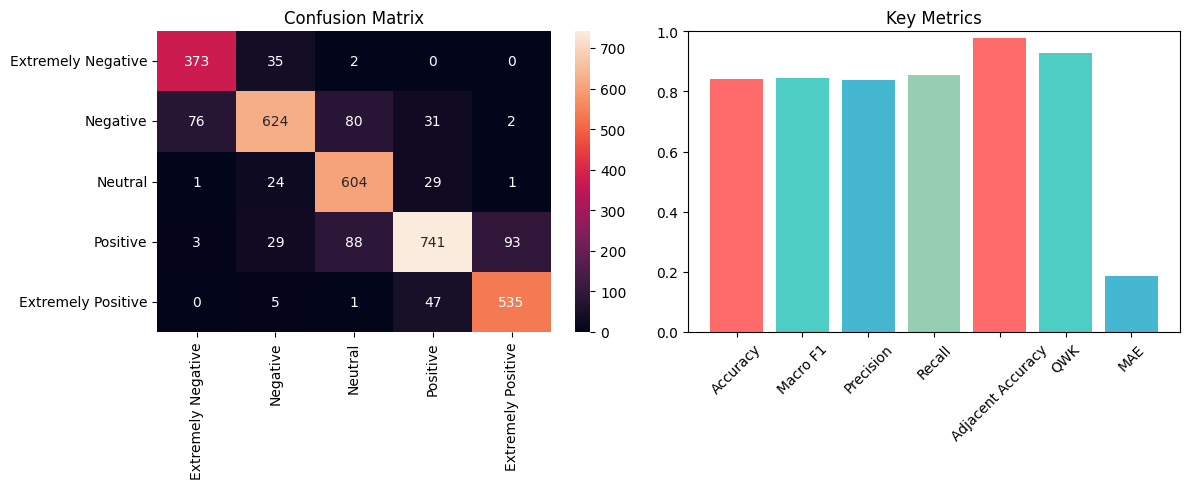

In [25]:
# Use the best model that was saved
optimal_batch_size = study.best_params['batch_size']
test_dataset = TweetDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=optimal_batch_size, shuffle=False)

# Use the actual best model now
results = quick_eval_manual('best_model_optuna.pt', test_loader)

### Hyperparameter Tuning Results

In [26]:
# Check study results
print("=== STUDY RESULTS ===")
print(f"Best trial: {study.best_trial.number}")
print(f"Best QWK: {study.best_value:.4f}")
print(f"Best params: {study.best_params}")

# Compare all trials
print("\n=== ALL TRIALS ===")
for trial in study.trials:
    print(f"Trial {trial.number}: QWK = {trial.value:.4f}")

=== STUDY RESULTS ===
Best trial: 7
Best QWK: 0.9345
Best params: {'learning_rate': 0.00011137674835204488, 'batch_size': 64, 'label_smoothing': 0.113394801714666, 'epochs': 15, 'warmup_ratio': 0.14077254623725632, 'weight_decay': 0.1359792823200739, 'attention_dropout': 0.385660939987262, 'hidden_dropout': 0.35719138097972813}

=== ALL TRIALS ===
Trial 0: QWK = 0.9288
Trial 1: QWK = 0.7711
Trial 2: QWK = 0.9342
Trial 3: QWK = 0.7978
Trial 4: QWK = 0.9345
Trial 5: QWK = 0.7446
Trial 6: QWK = 0.9276
Trial 7: QWK = 0.9345


### Model Predictions Analysis

In [27]:
# Analyze what the best model is predicting
import torch
from torch.serialization import safe_globals
from transformers import RobertaForSequenceClassification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the entire model directly
with safe_globals({RobertaForSequenceClassification}):
    model = torch.load('./best_roberta_model_so_far/model_roberta.pt', map_location=device, weights_only=False)

model.to(device)
model.eval()

# Calculate model metrics
model_size_mb = get_model_size(model)
total_params, trainable_params = get_model_parameters(model)

# Get a sample batch for inference timing
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
sample_batch = next(iter(val_loader))
inference_time_ms = measure_inference_time(model, sample_batch, device)

# Check predictions on validation data
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Analyze predictions
from collections import Counter
pred_dist = Counter(all_predictions)
true_dist = Counter(all_true_labels)

print("=== BEST MODEL ANALYSIS ===")
print("=" * 60)
print("MODEL SPECIFICATIONS:")
print(f"   • Model Size: {model_size_mb:.2f} MB")
print(f"   • Total Parameters: {total_params:,}")
print(f"   • Trainable Parameters: {trainable_params:,}")
print(f"   • Inference Time: {inference_time_ms:.2f} ms per request")
print("=" * 60)
print("PREDICTION ANALYSIS:")
print(f"   • True label distribution: {dict(true_dist)}")
print(f"   • Predicted label distribution: {dict(pred_dist)}")
print(f"   • Unique predictions: {sorted(set(all_predictions))}")
print(f"   • Number of classes predicted: {len(set(all_predictions))}")
print("=" * 60)

if len(set(all_predictions)) == 5:
    print("✅ Model is predicting all 5 classes!")
elif len(set(all_predictions)) > 1:
    print(f"✅ Model is predicting {len(set(all_predictions))} classes (better than before!)")
else:
    print("❌ Model still predicting only 1 class")

print(f"📊 Efficiency Metrics:")
print(f"   • Parameters per MB: {total_params/model_size_mb:,.0f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


=== BEST MODEL ANALYSIS ===
MODEL SPECIFICATIONS:
   • Model Size: 475.51 MB
   • Total Parameters: 124,649,477
   • Trainable Parameters: 124,649,477
   • Inference Time: 202.14 ms per request
PREDICTION ANALYSIS:
   • True label distribution: {np.int64(2): 889, np.int64(1): 915, np.int64(3): 1275, np.int64(0): 488, np.int64(4): 790}
   • Predicted label distribution: {np.int64(2): 1007, np.int64(3): 1181, np.int64(0): 504, np.int64(1): 834, np.int64(4): 831}
   • Unique predictions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
   • Number of classes predicted: 5
✅ Model is predicting all 5 classes!
📊 Efficiency Metrics:
   • Parameters per MB: 262,140
